In [1]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def color_string(order, s : str):
    if order in [6, 8]:
        return bcolors.FAIL + s + bcolors.ENDC
    else:
        return s

In [79]:
from typing import List, Dict
from enum import Enum

class ResourceType(Enum):
    NotSet = 0
    Tree = 1
    Grain = 2
    Steal = 3
    Sheep = 4
    Ground = 5
    Sea = 6
    UnCharted = 7
    OutOfRange = 8
    
class Gift:
    odds = {
        -1 : 0,
        2 : 1,
        3 : 2,
        4 : 3,
        5 : 4,
        6 : 5,
        8 : 5,
        9 : 4,
        10 : 3,
        11 : 2,
        12 : 1
    }
    
    def __init__(self, coord: tuple, number: int=-1, type: ResourceType=ResourceType.OutOfRange):
        assert(number in Gift.odds.keys())
        
        self.number = number
        self.type = type
        self.coord = coord
        self.neighbors : List[Gift] = []
        self.harbors : List[ResourceType] = []
    

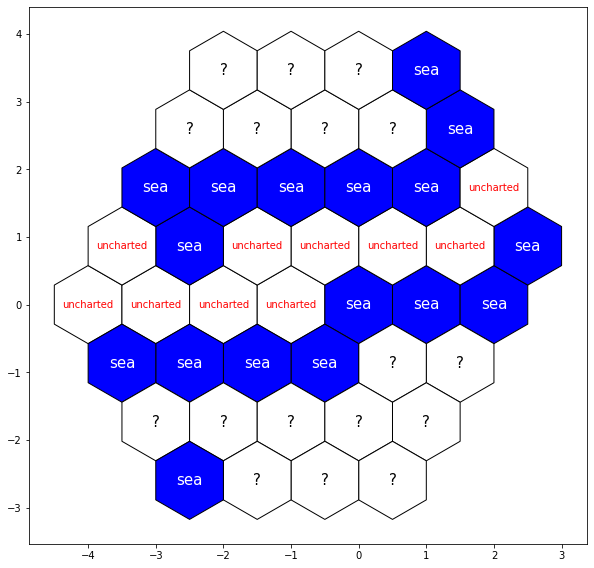

In [77]:
catan.generate(gifts=[51, 53, 55, 49, 47, 45, 43, 16, 14, 32, 34, 30, 28, 26, 44, 46, 48],
               seas=[25,27,29,31,21,33,41,57, 11, 6, 5, 4, 18, 20, 22, 24, 50],
               uncharted=[13, 15, 17, 19, 3, 2, 1, 0, 23, 35],
               numbers=[2, 3, 3, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11, 12],
               types=[ResourceType.Grain, ResourceType.Grain, ResourceType.Grain,
                      ResourceType.Sheep, ResourceType.Sheep, ResourceType.Sheep, ResourceType.Sheep,
                      ResourceType.Steal, ResourceType.Steal, ResourceType.Steal,
                      ResourceType.Ground, ResourceType.Ground, ResourceType.Ground
                      ResourceType.Tree, ResourceType.Tree, ResourceType.Tree, ResourceType.Tree])
catan.draw()

In [181]:
from re import I
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import numpy as np
import math

class Board:
    radius = np.sqrt(1/3)
    def __init__(self, size: tuple):
        assert(len(size) == 2)
        assert(all(s > 0 for s in size))
        self.size = size
        
        self.gifts = self.__initialize_hex_map__()
        
    def __transform(self, row: int, col: int):
        assert(row >= 0 and col >= 0)
        
        x = (2 * col + row) * Board.radius * math.cos(math.radians(30))
        y = row * 3 / 2 * Board.radius
        
        return x, y
        
        
    def __initialize_hex_map__(self) -> Dict[tuple, Gift]:
        gifts = {}
        rows, cols = self.size
        for row in range(rows):
            for col in range(cols):
                gifts[(row, col)] = Gift(coord=self.__transform(row, col))
        return gifts
    
    def draw(self):
        fig, ax = plt.subplots(1)
        ax.set_aspect('equal')

        for n, gift in self.gifts.items():
            if gift.type == ResourceType.NotSet:
                hex = RegularPolygon(gift.coord, numVertices=6, radius=Board.radius, alpha=1, edgecolor='k', facecolor='w')
                ax.add_patch(hex)
                plt.text(*gift.coord, "?", fontsize = 15, ha='center', va='center', color='k')
            elif gift.type == ResourceType.Sea:
                hex = RegularPolygon(gift.coord, numVertices=6, radius=Board.radius, alpha=1, edgecolor='k', facecolor='b')
                ax.add_patch(hex)
                plt.text(*gift.coord, "sea", fontsize = 15, ha='center', va='center', color='w')
            elif gift.type == ResourceType.UnCharted:
                hex = RegularPolygon(gift.coord, numVertices=6, radius=Board.radius, alpha=1, edgecolor='k', facecolor='w')
                ax.add_patch(hex)
                plt.text(*gift.coord, "uncharted", fontsize = 10, ha='center', va='center', color='r')
            # else:
                # hex = RegularPolygon(gift.coord, numVertices=6, radius=Board.radius, alpha=1, edgecolor='k', facecolor='k')
                # ax.add_patch(hex)
                # plt.text(*gift.coord, f'{n}', fontsize = 15, ha='center', va='center', color='w')
            
        plt.autoscale(enable = True)
        plt.show()

    def generate(self):
        
        for n in gifts:
            self.gifts[n].type = ResourceType.NotSet
        
        for n in seas:
            self.gifts[n].type = ResourceType.Sea
            
        for n in uncharted:
            self.gifts[n].type = ResourceType.UnCharted
    
class FogIsland(Board):
    def __init__(self):
        size = (8, 8)
        super().__init__(size)
        
        not_set = [
                    (0, 4), (0, 5), (0, 6),
                    (1, 2), (1, 3), (1, 4), (1, 5), (1, 6),
                    (2, 5), (2, 6),
                    (6, 0), (6, 1), (6, 2), (6, 3),
                    (7, 0), (7, 1), (7, 2),
        ]
    
        uncharted = [
                        (3, 0), (3, 1), (3, 2), (3, 3),
                        (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6),
                        (5, 5)
        ]
        
        seas = [
            (0, 3),
            (2, 1), (2, 2), (2, 3), (2, 4),
            (3, 4), (3, 5), (3, 6),
            (5, 0), (5, 1), (5, 2), (5, 3), (5, 4),
            (6, 4),
            (7, 3)
        ]
        
        for row, col in not_set:
            self.gifts[(row, col)].type = ResourceType.NotSet
        
        for row, col in uncharted:
            self.gifts[(row, col)].type = ResourceType.UnCharted
            
        for row, col in seas:
            self.gifts[(row, col)].type = ResourceType.Sea

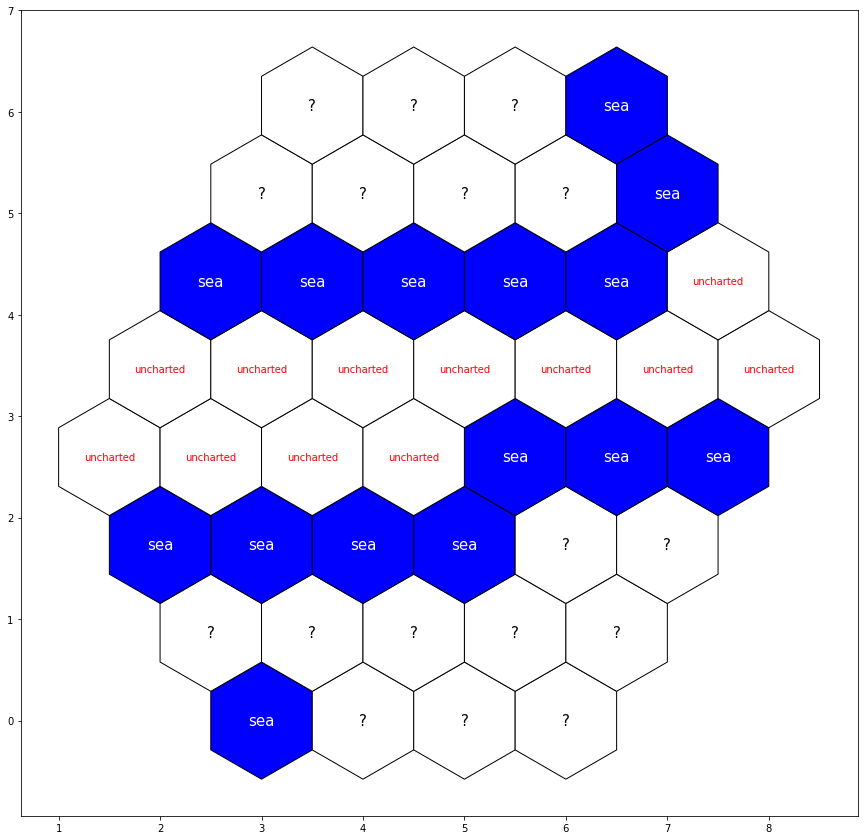

In [182]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]
catan = FogIsland()
catan.draw()